# 2023-08-30__STA_conntest

(Result of workflow speed (& ergonomy) tests: full Julia (no Python hybrid))

So, for all 10 Ns;\
For 10 diff seeds;
for both exc, inh, and unconn;\
we conntest (maximum) 100 input spike trains.\
(Each test is comprised of calculating 101 STAs: one real and the rest with shuffled ISIs).

From the prev nb (https://tfiers.github.io/phd/nb/2023-08-16__STA_conntest_pyjulia.html),
we found we'd take a shorter window, so that 'area over start' measure (to determine if exc or inh) is correct.

But ok, it's good to show that in thesis.\
So, we repeat an example STA plot here.

for full N ofc.

In [1]:
N = 6500;

In [2]:
@time using Revise

  0.407060 seconds (595.27 k allocations: 36.056 MiB, 1.32% compilation time)


In [3]:
using Nto1AdEx
using Units

In [4]:
duration = 10minutes

600.0

In [5]:
@time sim = Nto1AdEx.sim(N, duration);

  2.405747 seconds (868.61 k allocations: 968.860 MiB, 2.36% gc time, 31.13% compilation time)


(1st run: 2.5 secs, 27% compilation time).

In [6]:
@time using ConnectionTests

  0.080130 seconds (99.44 k allocations: 7.290 MiB)


We want our input spiketrains sorted: the highest spikers first.\
And split exc/inh, too.

In [7]:
using DataFrames

In [8]:
ENV["DATAFRAMES_ROWS"] = 10;

In [9]:
exc_inputs = highest_firing(excitatory_inputs(sim))

tabulate(trains) = DataFrame(
    "# input spikes" => num_spikes.(trains),
    "spike rate (Hz)" => spikerate.(trains)
)
tabulate(exc_inputs)

Row,# input spikes,spike rate (Hz)
,Int64,Float64
1,58522,97.5367
2,35312,58.8533
3,24428,40.7133
4,20653,34.4217
5,18898,31.4967
⋮,⋮,⋮
5196,194,0.323333
5197,185,0.308333
5198,175,0.291667


In [10]:
inh_inputs = highest_firing(inhibitory_inputs(sim))

tabulate(inh_inputs)

Row,# input spikes,spike rate (Hz)
,Int64,Float64
1,21808,36.3467
2,21054,35.09
3,16402,27.3367
4,14905,24.8417
5,14429,24.0483
⋮,⋮,⋮
1296,234,0.39
1297,220,0.366667
1298,218,0.363333


( :) )

In [11]:
STA = calc_STA(sim.V, exc_inputs[1].times);

In [12]:
using WithFeedback

In [13]:
@withfb import PythonCall
@withfb import PythonPlot
@withfb using Sciplotlib
@withfb using PhDPlots

import PythonCall … ✔ (2.1 s)
import PythonPlot … ✔ (2.9 s)
using Sciplotlib … ✔ (0.7 s)
using PhDPlots … 

[ Info: Precompiling PhDPlots [8882fb83-7a18-4ae0-b3ef-a58e1f4042a1]


✔ (3.1 s)


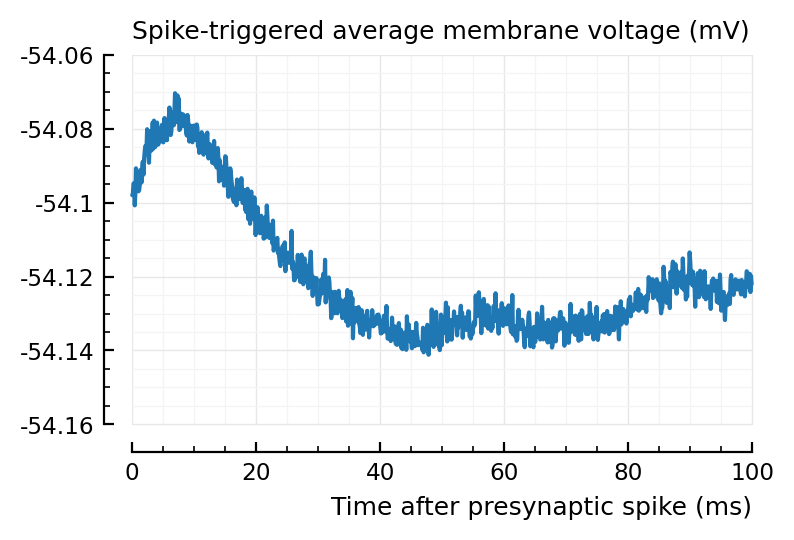

In [39]:
plotSTA(STA);

To compare with predicted PSP height (0.04 mV):

In [15]:
(maximum(STA) - first(STA)) / mV

0.027582126445102606

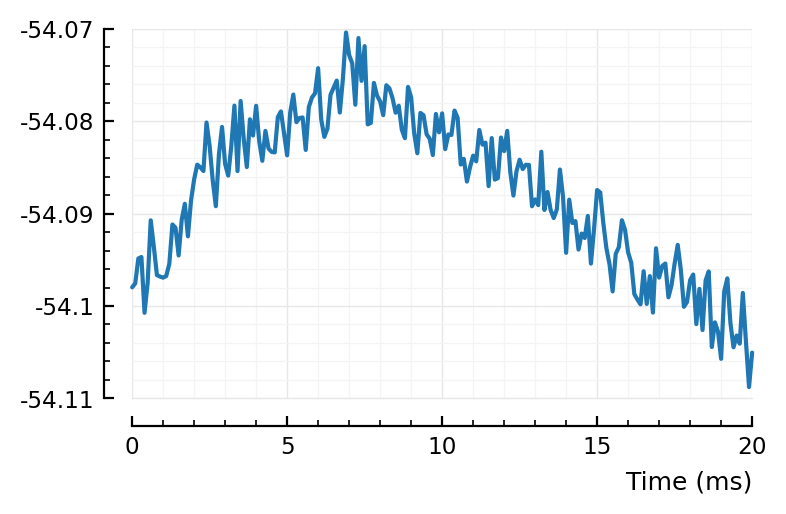

In [40]:
plotsig(STA/mV, [0,20], ms);

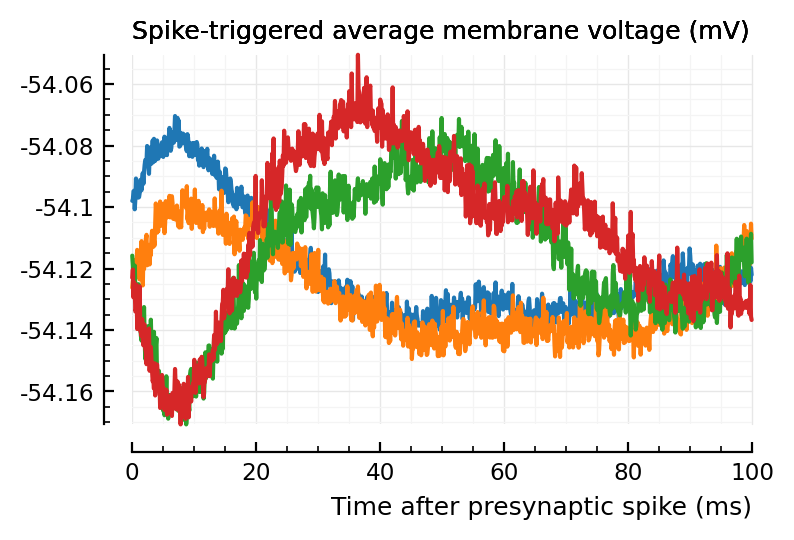

In [90]:
plotSTA_(train; kw...) = begin
    nspikes = num_spikes(train)
    EI = train ∈ exc_inputs ? "exc" : "inh"
    label = "$nspikes spikes, $EI"
    plotSTA(calc_STA(sim.V, train.times); label, kw...)
end
    
plotSTA_(exc_inputs[1]);
plotSTA_(exc_inputs[2]);
plotSTA_(inh_inputs[1]);
plotSTA_(inh_inputs[2]);

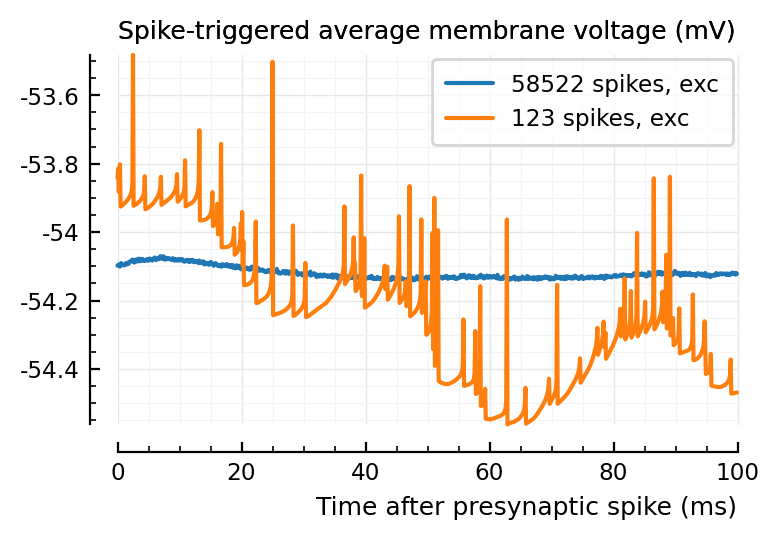

In [91]:
plotSTA_(exc_inputs[1]);
plotSTA_(exc_inputs[end]);
plt.legend();

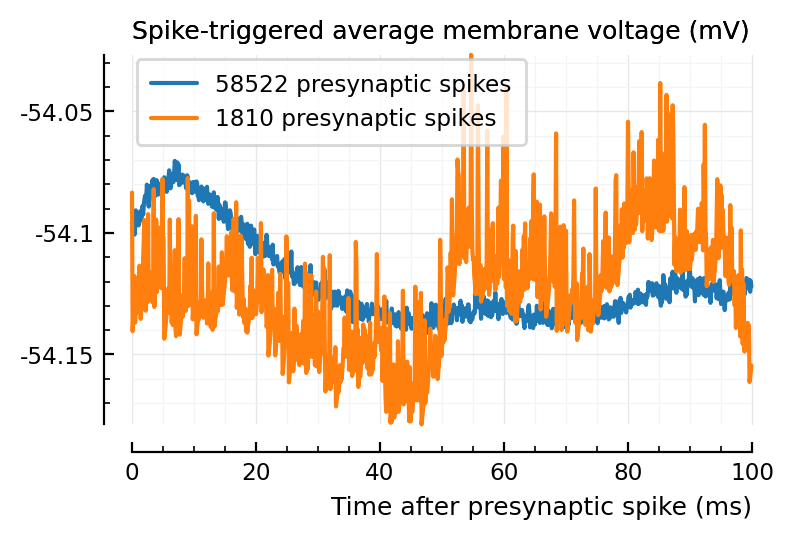

In [46]:
mid = length(exc_inputs) ÷ 2

plotSTA_(exc_inputs[1]);
plotSTA_(exc_inputs[mid]);
plt.legend();

Saved at `../thesis/figs/example_STAs.pdf`

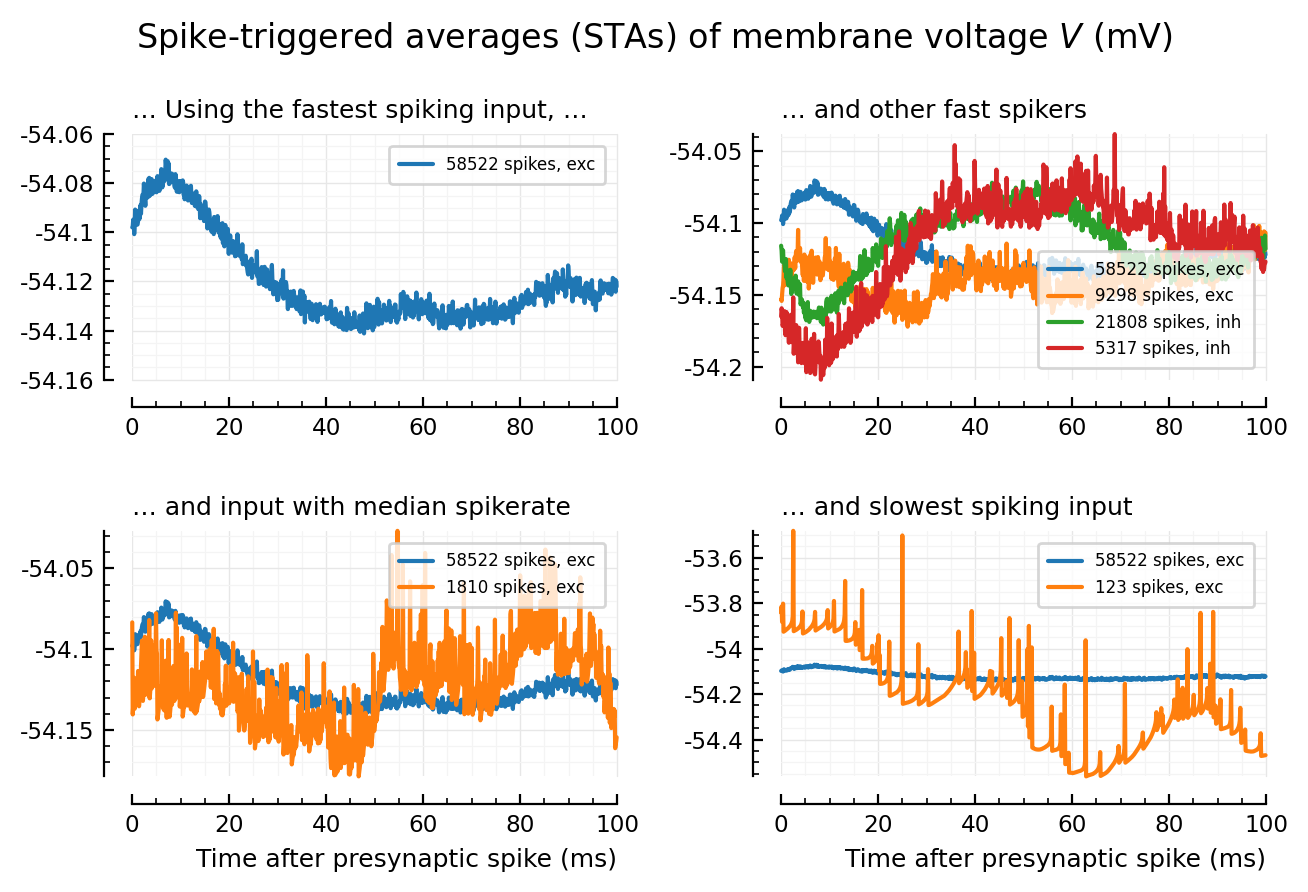

In [124]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(pw*0.8, mtw))
plotSTA_2(args...; hylabel=nothing, kw...) = plotSTA_(args...; hylabel, kw...)

addlegend(ax; kw...) = legend(ax, fontsize=6, borderaxespad=0.7; kw...)

plotSTA_2(exc_inputs[1], ax=axs[0,0], hylabel="… Using the fastest spiking input, …", xlabel=nothing);
addlegend(axs[0,0])

plotSTA_2(exc_inputs[1], ax=axs[0,1], hylabel="… and other fast spikers", xlabel=nothing);
plotSTA_2(exc_inputs[100], ax=axs[0,1], xlabel=nothing)
plotSTA_2(inh_inputs[1], ax=axs[0,1], xlabel=nothing)
plotSTA_2(inh_inputs[100], ax=axs[0,1], xlabel=nothing)
addlegend(axs[0,1], loc="lower right")


plotSTA_2(exc_inputs[1], ax=axs[1,1], hylabel="… and slowest spiking input");
plotSTA_2(exc_inputs[end], ax=axs[1,1]);
addlegend(axs[1,1])

plotSTA_2(exc_inputs[1], ax=axs[1,0], hylabel="… and input with median spikerate");
plotSTA_2(exc_inputs[mid], ax=axs[1,0]);
addlegend(axs[1,0], loc="upper right")

plt.suptitle(L"Spike-triggered averages (STAs) of membrane voltage $V$ (mV)")

plt.tight_layout(h_pad=2);

savefig_phd("example_STAs")